# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 02

**Author 1 (sciper):** Basile Spaenlehauer (272570)

**Author 2 (sciper):** Victor Herrmann (284552)

**Author 3 (sciper):** Abed Alrahman Shabaan (237731)

**Release date:** 12.03.2021  
**Due date:** 26.03.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* Additional method of your choice (5 pts)

Each section should display the resulting segmenttion as well as the size in pixel of the detected region. Comment each method limitations and/or advantages.

### 1.1 Brain image visualization

In [2]:
# imports
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sys
import threading
from skimage.feature import canny
from skimage.morphology import binary_closing
from skimage.filters import median
from skimage.exposure import equalize_hist
from sklearn.cluster import KMeans


# increase limit for recursive function
sys.setrecursionlimit(256*256)
threading.stack_size(1024*1024*128) #128 MB


0

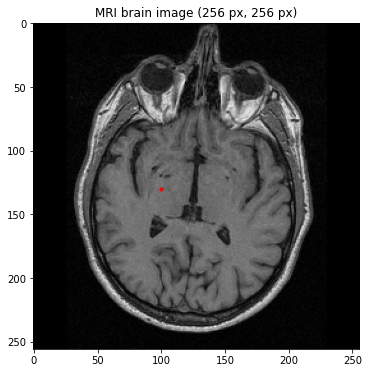

In [3]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# initialize the seed for growing
init_pix = (130, 100)

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
# ax.axis('off')
plt.scatter(init_pix[1], init_pix[0], color='r', marker='.')
plt.show()

Note that we drew a single red pixel on top of the image. That pixel will be used to seed the region growing algorithm.

### 1.2 Region growing (5pts)

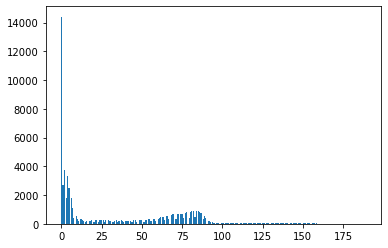

In [4]:
# plot the histogram to get a feel for the image
plt.hist(brain_im.flatten(), bins=256)
plt.show()

The histogram of our image seems to be dominated by zeros, that's the background. The hill around 80 is the brain. The brighter skull is the tail that's above 100 approximately.

In [5]:
# initialize a global vaiable for the region growing algo
img_mask = None

def init_im_mask(shape):
    global img_mask
    img_mask = -1*np.ones(shape)
    

# init_im_mask(brain_im.shape)

# # plot
# plt.imshow(img_mask, vmin=-1, vmax=1)
# plt.title("Initialized mask for region growing")
# plt.colorbar()
# plt.show()

In [6]:
# region growing algorithm
def region_growing(img, curr_pix, criterion, neighbourhood_4=False):
    """ Perform region growing recursively from prosition curr_pix in img
    criterion: a boolean function that compares 2 pixels and return True if they are considered similar
    neighbourhood_4: only search the pixel on a cross patern (no diagonals)
    """
    global img_mask
    for i in range(-1,2):
        for j in range(-1,2):
            # don't search the curr_pix and don't go outside te image boudary
            if (i!=0 or j!=0) and 0 <= curr_pix[0] + i < img.shape[0] and 0 < curr_pix[1] + j < img.shape[1]:
                if neighbourhood_4 and i and j: # Avoid diagonals if considering 4-neighbourhoods
                    continue
                # pixel was not searched
                if img_mask[curr_pix[0]+i, curr_pix[1]+j] == -1:
                    if criterion(img[curr_pix], img[curr_pix[0]+i, curr_pix[1]+j]):
                        img_mask[curr_pix[0]+i, curr_pix[1]+j] = 1
                        region_growing(img, (curr_pix[0]+i, curr_pix[1]+j), criterion)
                    else:
                        img_mask[curr_pix[0]+i, curr_pix[1]+j] = 0
                        

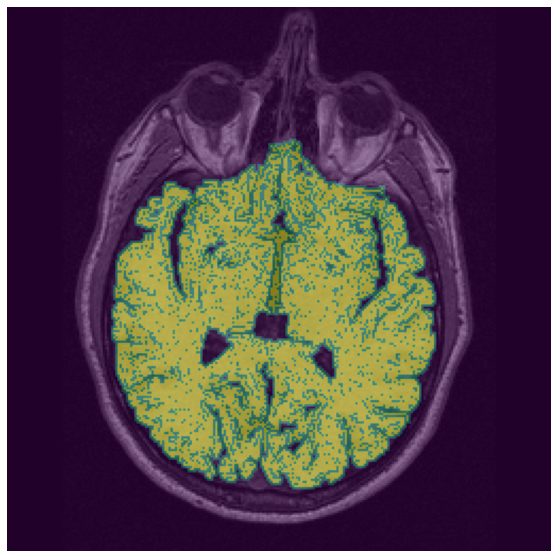

In [7]:
# init mask for region growing
init_im_mask(brain_im.shape)

thread = threading.Thread(target=region_growing, args=(brain_im, init_pix, lambda x,y: np.abs(int(x) - int(y)) < 8))
thread.start()
thread.join()

# plot
plt.figure(figsize=(10, 10))
plt.imshow(brain_im, cmap='gray')
plt.imshow(img_mask, alpha=0.5)
plt.axis('off')
plt.show()

Let's print the number of the mask's pixels. This is our estimation of the brain's size in pixels

In [8]:
pixels_region = (img_mask >= 0).sum()
print(f'The brain has {pixels_region} pixels')

The brain has 18223 pixels


#### Discussion:
The region growing method on the non-thresholded image gave us a reasonable estimate, although we can see that some non-brain regions that are similar to the brain are included in the mask.

Note that we counted all the pixels considered to be at the limit of the brain shape to be of the brain as well. So all the blue pixels in the mask above. This decision was motivated by the large number of such pixels inside the brain.

### 1.3 Contour detection (5pts)


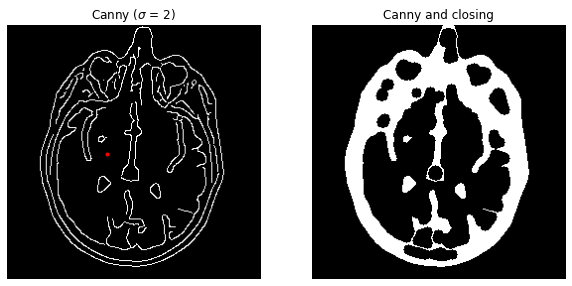

In [9]:
# define sigma for canny
canny_sigma = 2

# perform edge detection with canny
edges = canny(brain_im, sigma=canny_sigma)
# perform closing
closed_edges = binary_closing(edges, selem=skimage.morphology.disk(5))

# plot
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title(f'Canny ($\sigma$ = {canny_sigma})')
plt.imshow(edges, cmap='gray')
plt.scatter(x=init_pix[1], y=init_pix[0], c='r', marker='.')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Canny and closing')
plt.imshow(closed_edges, cmap='gray')
plt.axis('off')
plt.show()

Note that we closed the detected edges to be able to do the next step, which is to use region growing inside the brain border to find the number of pixels inside the brain

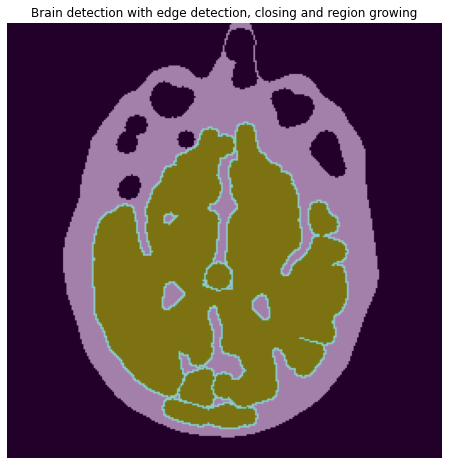

In [10]:
# init mask for region growing
init_im_mask(brain_im.shape)

thread = threading.Thread(target=region_growing, args=(closed_edges, init_pix, lambda x,y: x == y, True))
thread.start()
thread.join()

# plot
plt.figure(figsize=(8, 8))
plt.imshow(closed_edges, cmap='gray')
plt.imshow(img_mask, alpha=0.5)
plt.title('Brain detection with edge detection, closing and region growing')
plt.axis('off')
plt.show()

In [11]:
pixels_contour = (img_mask == 1).sum()
print(f'Using the contour detection method, the brain has {pixels_contour} pixels')
print(f'This is {pixels_region - pixels_contour} less than plain region growing')

Using the contour detection method, the brain has 15783 pixels
This is 2440 less than plain region growing


#### Discussion:
We note a couple of things:

* Using the edge detector before doing region growing causes us to lose some regions where there are a lot of details (near the eyes) because edges are detected there.
* We may have to do some morphological transformation after edge detection to close the contours and have a separate region in which we can count the pixels.
* This method has more parameters to tune, but gives a more homogeneous result compared to plain region growing. At the price of losing some external regions because the contours were discontious and became completely external after closing.


### 1.4 Additional method (5pts)
We choose to filter the orignial image before applying region growing

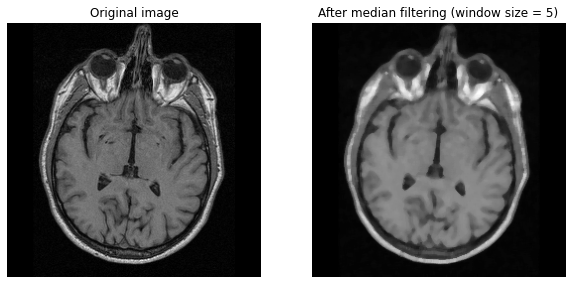

In [12]:
# median filtering with a rolling window of 5x5 pixels
window_size = 5
median_filtered = median(brain_im, selem=np.ones((window_size, window_size)))

# plot
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(brain_im, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(median_filtered, cmap='gray')
plt.title(f'After median filtering (window size = {window_size})')
plt.axis('off')
plt.show()

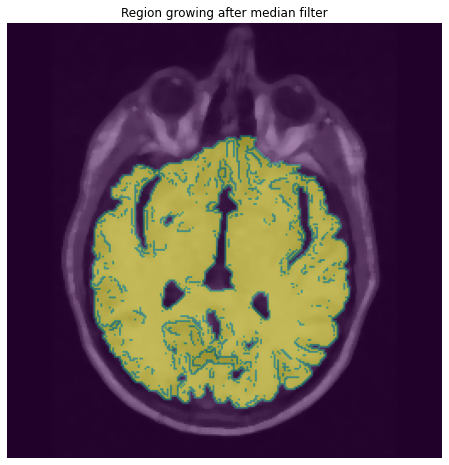

In [13]:
init_im_mask(median_filtered.shape)

thread = threading.Thread(target=region_growing, args=(median_filtered, init_pix, lambda x,y: np.abs(int(x)-int(y)) < 5))
thread.start()
thread.join()

# plot
plt.figure(figsize=(8, 8))
plt.imshow(median_filtered, cmap='gray')
plt.imshow(img_mask, alpha=0.5)
plt.title('Region growing after median filter')
plt.axis('off')
plt.show()

In [14]:
pixels_median = (img_mask >= 0).sum()
print(f'Using the contour detection method, the brain has {pixels_median} pixels')
print(f'This is {pixels_median - pixels_contour} more than contour detection and {pixels_median - pixels_region} more than plain region growing')

Using the contour detection method, the brain has 17749 pixels
This is 1966 more than contour detection and -474 more than plain region growing


#### Discussion:
* We notice that the filtering with a median removed the small variations inside the brain and allowed us to have a more pleasing result while keeping a lower similarity threshold than plain region growing
* We also notice that we exclude the regions in the center of the image which are not part of the brain, we weren't able to do this before using plain region growing because we had to keep a higher similarity threshold.
* We have a more homogeneous result than in plain region growing, this is thanks to the filter eliminating smaller variations inside the brain region

#### Conclusion
For this application, this last method seems to be the most appropriate of all three.

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity normalization should probably be used.

### 2.1 Visualization

In [15]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

Number of images:  3
Image size: 480, 640 
Number of color channels:  3


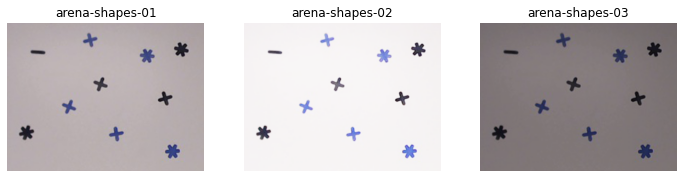

In [16]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

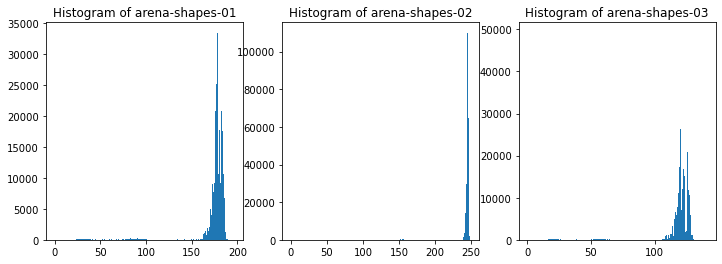

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.hist(im.mean(axis=2).flatten(), bins=256)
    ax.set_title(f'Histogram of {nm}')
plt.show()

We start by equalising the histograms to be robust to illumination changes

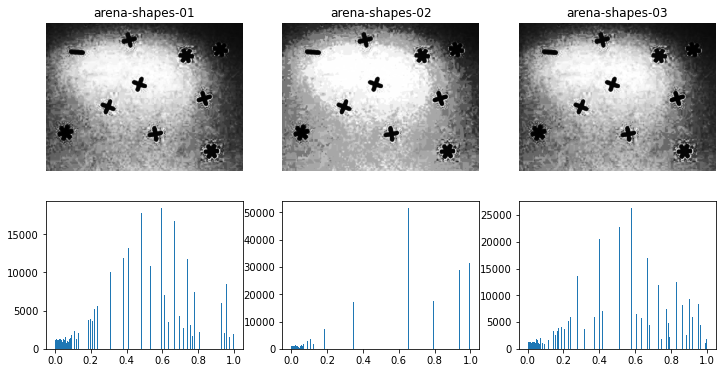

In [18]:
equalized = np.empty(images.shape[0:3])
plt.subplots(2, 3, figsize=(12, 6))
for i,im in enumerate(images):
    equalized[i,:,:] = equalize_hist(im.mean(axis=2))
    plt.subplot(2, 3, i+1)
    plt.imshow(equalized[i], cmap='gray')
    plt.title(im_names[i])
    plt.axis('off')
    plt.subplot(2, 3, i+4)
    plt.hist(equalized[i].flatten(), bins=256)

plt.show()

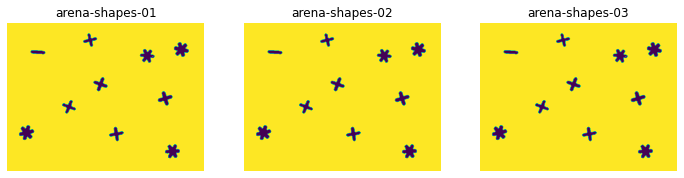

In [19]:
# define the threshold for fg/bg
thresh = 0.03

# create a mask with the threshold
masks = equalized <= thresh
masks = masks.astype(np.int8)

plt.subplots(1, 3, figsize=(12, 4))
for i,im in enumerate(images):
    plt.subplot(1, 3, i+1)
    plt.imshow(np.logical_not(masks[i]))
    plt.title(im_names[i])
    plt.axis('off')
plt.show()

Note that the histogram equalisation allowed us to use the same threshold for all 3 images.

### 2.2 Number of shapes of each color (5 pts)

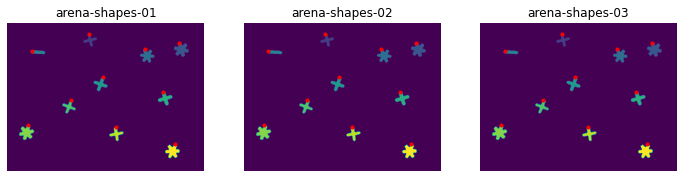

In [20]:
# make a copy of the masks to be able to run the cell multiple times
label_masks = masks.copy()

plt.subplots(1, 3, figsize=(12, 4))
for i, mask in enumerate(label_masks):
    # init the label at 2 (0 is back, 1 is foreground)
    current_element = 2
    entry_points = []
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            # only if pixel is in the foreground
            if mask[row, col] == 1:
                entry_points.append((row, col))
                init_im_mask(mask.shape)
                # region growing
                thread = threading.Thread(target=region_growing, args=(mask, (row, col), lambda x, y: x == y))
                thread.start()
                thread.join()
                # label all the pixels identified by the region growing
                mask[img_mask == 1] = current_element
                current_element += 1

    plt.subplot(1, 3, i+1)
    plt.imshow(mask)
    plt.scatter(x=[x[1] for x in entry_points], y=[x[0] for x in entry_points], c='r', marker='.')
    plt.title(im_names[i])
    plt.axis('off')

plt.show()

Note here the red points are the entry points for the region growing, so they are the first pixel that was used to label the object.

In [21]:


# initialize arrays for clustering and area computing
clusters = np.empty((3, 10))
nb_pixels = np.empty((3, 10))
nbr_colors = 2

for i,img in enumerate(images):
    colors = []
    objects = np.unique(label_masks[i])[1:] # Number of all unique values except the background
    for j, obj in enumerate(objects):
        original_object = img[label_masks[i] == obj]
        mean_color = original_object.mean(axis=0)
        colors.append(mean_color)
        nb_pixels[i, j] = original_object.shape[0]

    # use kmeans to cluster the shapes of same color
    kmeans = KMeans(n_clusters=nbr_colors, random_state=42).fit(np.array(colors))
    clusters[i] = kmeans.predict(colors)
    print(f'For image {im_names[i]} we have {(clusters[i] == 0).sum()} blue objects and {(clusters[i] == 1).sum()} grey ones')


For image arena-shapes-01 we have 5 blue objects and 5 grey ones
For image arena-shapes-02 we have 5 blue objects and 5 grey ones
For image arena-shapes-03 we have 5 blue objects and 5 grey ones


As you see, we were able to retrieve the number of objects per colour using unsupervised learning to group the objects of the same mean color (Kmeans).

### 2.3 Total area (in pixels) of each color (5 pts)

In [22]:
# Add your implementation and discussion
for i,name in enumerate(im_names):
    print(f'For image {name} we have {nb_pixels[i,clusters[i] == 0].sum():.0f} blue pixels and {nb_pixels[i,clusters[i] == 1].sum():.0f} grey pixels')

For image arena-shapes-01 we have 4433 blue pixels and 4759 grey pixels
For image arena-shapes-02 we have 4480 blue pixels and 4726 grey pixels
For image arena-shapes-03 we have 4438 blue pixels and 4762 grey pixels


We see very consistent results, the slight variation is due to using the same threshold for segmentation after having equalised the histograms.